Khai báo

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Import dữ liệu

In [5]:
drive_path = 'drive/MyDrive/Internship/RNN/Temp'
excel_path = drive_path + '/Data/Data.xlsx'

df = pd.read_excel(excel_path)
date_time = pd.to_datetime(df.pop('Ngày giờ'), format='%Y-%m-%d %H:%M:%S')

Xử lý dữ liệu

In [6]:
for index, value in enumerate(df['Áp suất']):
  if value > 0:
    pass
  else:
    df['Áp suất'][index] = df['Áp suất'].mean()

for index, value in enumerate(df['Tầm nhìn']):
  if value > 0:
    pass
  else:
    df['Tầm nhìn'][index] = df['Tầm nhìn'].mean()

for index, value in enumerate(df['Chỉ số UV']):
  if value > 0:
    pass
  else:
    df['Chỉ số UV'][index] = df['Chỉ số UV'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
df['Xác suất mưa'] = df['Xác suất mưa'] / 100

In [8]:
le = preprocessing.LabelEncoder()
df['Trạng thái mưa'] = le.fit_transform(df['Trạng thái mưa'])
df['Kết luận'] = le.fit_transform(df['Kết luận'])

Phân tích dữ liệu

In [9]:
wv = df.pop('Tốc độ gió')

wd_rad = df.pop('Hướng gió') * np.pi / 180

df['Gió X'] = wv * np.cos(wd_rad)
df['Gió Y'] = wv * np.sin(wd_rad)

In [10]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Ngày sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Ngày cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Năm sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Năm cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Chia dữ liệu

In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Chuẩn hóa dữ liệu

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Lớp WindowGenerator

In [13]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Tổng kích thước cửa sổ: {self.total_window_size}',
        f'Chỉ số đầu vào: {self.input_indices}',
        f'Chỉ số nhãn: {self.label_indices}',
        f'Tên cột: {self.label_columns}'])

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
def plot(self, model=None, plot_col='Nhiệt độ', max_subplots=1):
  inputs, labels = self.example
  plt.figure(figsize=(15, 10))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [Định mức]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Đầu vào', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Nhãn', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Dự đoán', c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Thời gian [h]')

WindowGenerator.plot = plot

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train))
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Hàm training

In [18]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='auto')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train,
                      epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Mô hình

In [19]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units, activation='relu')
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [20]:
def warmup(self, inputs):
  x, *state = self.lstm_rnn(inputs)

  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [21]:
def call(self, inputs, training=None):
  predictions = []
  prediction, state = self.warmup(inputs)

  predictions.append(prediction)

  for n in range(1, self.out_steps):
    x = prediction
    x, state = self.lstm_cell(x, states=state, training=training)
    prediction = self.dense(x)
    predictions.append(prediction)

  predictions = tf.stack(predictions)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [22]:
multi_val_performance = {}
multi_performance = {}

In [23]:
IN_STEPS = 24
OUT_STEPS = 6
STEPS = 1
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=STEPS)

In [24]:
feedback_model = FeedBack(units=64, out_steps=OUT_STEPS)

In [25]:
prediction, state = feedback_model.warmup(multi_window.example[0])

In [26]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

148/148 [==============================] - 1s 7ms/step - loss: 0.1172 - mean_absolute_error: 0.2016


In [34]:
drive_path = 'drive/MyDrive/Internship/RNN/Temp/Model/'
Model_name = 'Model_' + str(IN_STEPS) + '_' + str(OUT_STEPS) + '_' + str(STEPS)

Lưu model

In [28]:
feedback_model.save(drive_path + Model_name, save_format='tf')

Load model

In [29]:
del feedback_model
feedback_model = tf.keras.models.load_model(drive_path + Model_name)

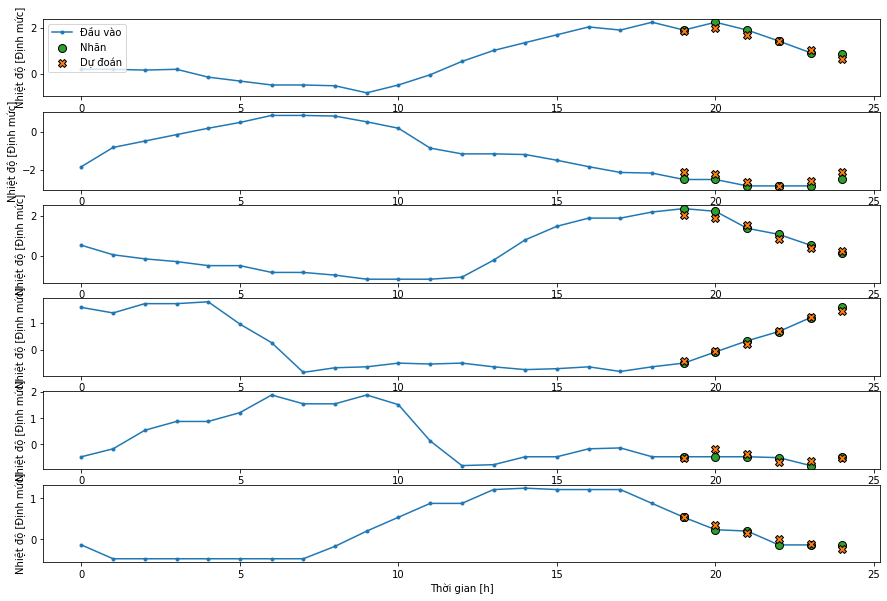

In [31]:
multi_window.plot(model=feedback_model, max_subplots=6, plot_col='Nhiệt độ')

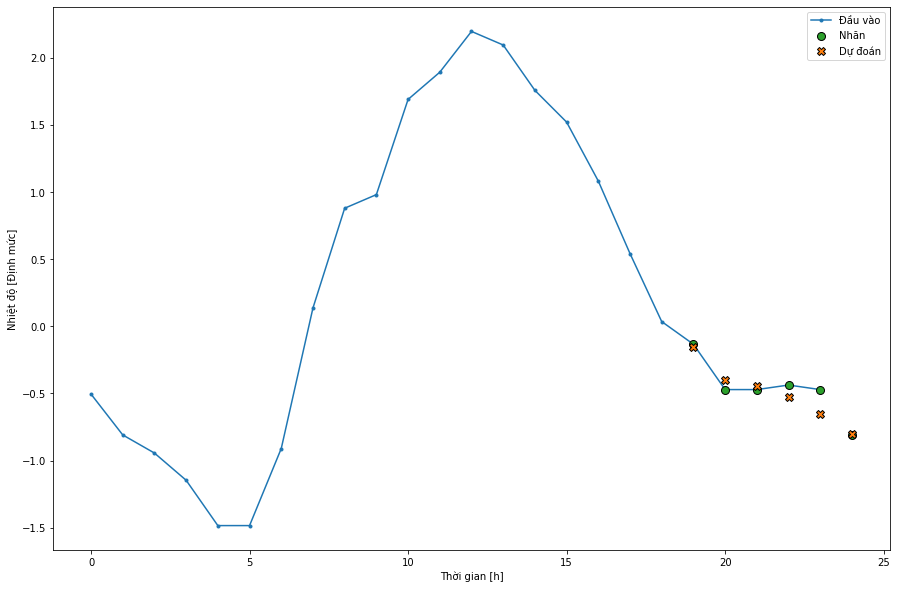

In [35]:
days12 = df[-6:]
check_df = (days12 - days12.mean()) / days12.std()

IN_STEPS = 24
OUT_STEPS = 6
STEPS = 1
Model_name = 'Model_' + str(IN_STEPS) + '_' + str(OUT_STEPS) + '_' + str(STEPS)
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=STEPS,
                               test_df=check_df)

del feedback_model
feedback_model = tf.keras.models.load_model(drive_path + Model_name)

multi_window.plot(model=feedback_model, max_subplots=1, plot_col='Nhiệt độ')